In [17]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [18]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [19]:
NUM_CLASSES = 6

# 学習データ読み込み

In [20]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [21]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [24]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [26]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [27]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/51 [..............................] - ETA: 12s - loss: 1.8891 - accuracy: 0.1953
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
51/51 [==============================] - 0s 3ms/step - loss: 1.7175 - accuracy: 0.2793 - val_loss: 1.5886 - val_accuracy: 0.3627
Epoch 2/1000
 1/51 [..............................] - ETA: 0s - loss: 1.5695 - accuracy: 0.3438
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
51/51 [==============================] - 0s 1ms/step - loss: 1.5211 - accuracy: 0.3637 - val_loss: 1.3902 - val_accuracy: 0.4019
Epoch 3/1000
 1/51 [..............................] - ETA: 0s - loss: 1.4331 - accuracy: 0.4219
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
51/51 [==============================] - 0s 1ms/step - loss: 1.3950 - accuracy: 0.4054 - val_loss: 1.2457 - val_accuracy: 0.4746
Epoch 4/1000
 1/51 [..............................] - ETA: 0s - loss: 1.3207 - accuracy: 0.4922


In [28]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

17/17 [==============================] - 0s 550us/step - loss: 0.3017 - accuracy: 0.9790


In [29]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [30]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 36ms/step
[8.7632912e-01 1.2337219e-01 3.3324671e-10 2.9663942e-04 3.2281058e-08
 1.9874740e-06]
0


# 混同行列

68/68 [==============================] - 0s 432us/step


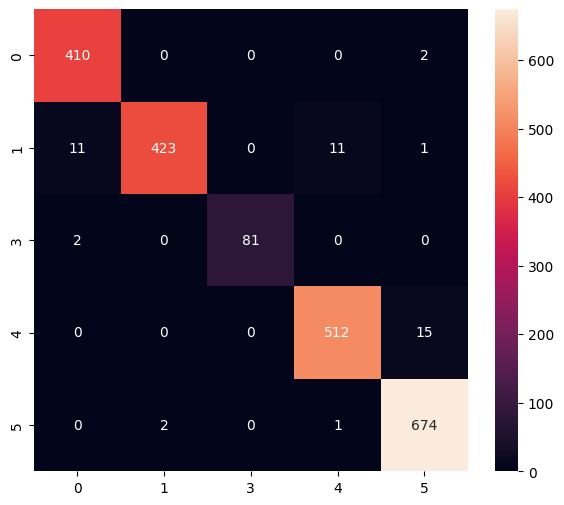

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       412
           1       1.00      0.95      0.97       446
           3       1.00      0.98      0.99        83
           4       0.98      0.97      0.97       527
           5       0.97      1.00      0.98       677

    accuracy                           0.98      2145
   macro avg       0.98      0.98      0.98      2145
weighted avg       0.98      0.98      0.98      2145



In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [32]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/Users/nathanchen/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/zv/p71gj8sx65zfm5gg91s7p3zr0000gn/T/tmpstwmjv2b/assets


INFO:tensorflow:Assets written to: /var/folders/zv/p71gj8sx65zfm5gg91s7p3zr0000gn/T/tmpstwmjv2b/assets
2023-10-17 12:51:23.261178: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-10-17 12:51:23.261208: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-10-17 12:51:23.261573: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/zv/p71gj8sx65zfm5gg91s7p3zr0000gn/T/tmpstwmjv2b
2023-10-17 12:51:23.262363: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-10-17 12:51:23.262369: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/zv/p71gj8sx65zfm5gg91s7p3zr0000gn/T/tmpstwmjv2b
2023-10-17 12:51:23.264197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-10-17 12:51:23.265183: I tensorflow/cc/saved_model/load

6660

# 推論テスト

In [34]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [35]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [36]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [37]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 135 µs, sys: 151 µs, total: 286 µs
Wall time: 188 µs


In [38]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.7632924e-01 1.2337214e-01 3.3324676e-10 2.9663934e-04 3.2281061e-08
 1.9874722e-06]
0
